In [ ]:
pip install pytsdatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 9.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


In [ ]:
#Leer base de datos
df = pd.read_csv('/content/drive/MyDrive/IA_avanzada/Estadística/Alcohol_Sales.csv', index_col="DATE", parse_dates=True)
df.columns = ["VENTAS"]


In [ ]:
df.head()

,VENTAS
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


# Función Test stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

    #kpss test:
    print('Results of kpss Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# Función periodgram

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(ts)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/12, 1/6, 1/4, 1/3, 1/2])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "3 months",
            "Bimonthly (6)",
            
            
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Análisis exploratorio

Revisamos si existen datos faltantes

In [ ]:
df.isnull().sum()

VENTAS    0
dtype: int64

# Prueba de estacionaridad 

In [ ]:
alc = df['VENTAS']

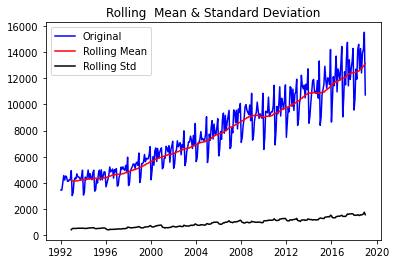

Results of Dickey-Fuller Test:
Test Statistic                   2.037405
p-value                          0.998720
#Lags Used                      14.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64
Results of kpss Test:
Test Statistic            1.898195
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
test_stationarity(alc)

**Resultados de la prueba de estacionariedad**

Como podemos observar en el gráfico, la parte azul es nuestro conjunto de datos originales, estos tienen un comportamiento con una tendencia positiva, por lo que la serie no es estacionaria. Además obtenemos el p-value con los resultados del test Dickey-Fuller, este tiene un valor de 0.998, el cual es mayor que el nivel de significancia 0.05 por lo que no es estacionaria. En este caso se necesitará realizarle una diferenciación a la serie para acercarse a un comportamiento estacionario.


## Estacionalidad

Se remueve la tendencia primero

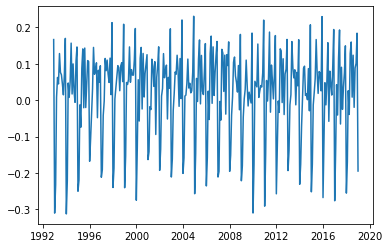

In [ ]:
#Removemos la tendencia
tslog = np.log(df['VENTAS'])
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

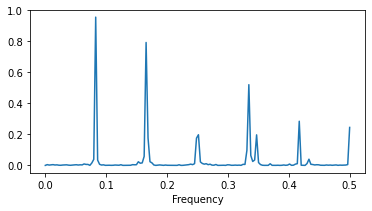

In [ ]:
from scipy import signal
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()


Utilizamos la función pediograma y vemos que existen valores signifivativos cerca de 0.1, 0.2, 0.3, 0.4 y 0.5.

In [ ]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]

In [ ]:
top_4_periods


{'period1': 12.076923076923075,
 'freq1': 0.08280254777070065,
 'power1': 0.9566375268095911,
 'period2': 6.038461538461537,
 'freq2': 0.1656050955414013,
 'power2': 0.7931631890197576,
 'period3': 2.99047619047619,
 'freq3': 0.33439490445859876,
 'power3': 0.520801384940602,
 'period4': 2.396946564885496,
 'freq4': 0.4171974522292994,
 'power4': 0.2848703419240082}

Como podemos observar la primera frecuencia más sobresaliente corresponde a un periodo de 12 meses y la segunda a un periodo semianual. Podemos observar esta información graficando utilizando la función periodgram y utilizando periodos y no frecuencia.

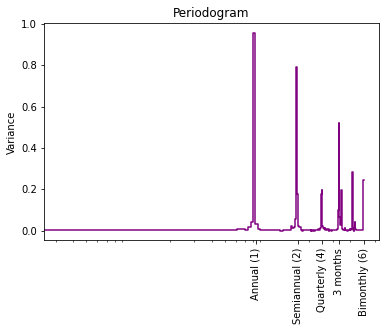

In [ ]:
plot_periodogram(tslogdiff)
plt.show()

# Pruebas de autocorrelación preliminares

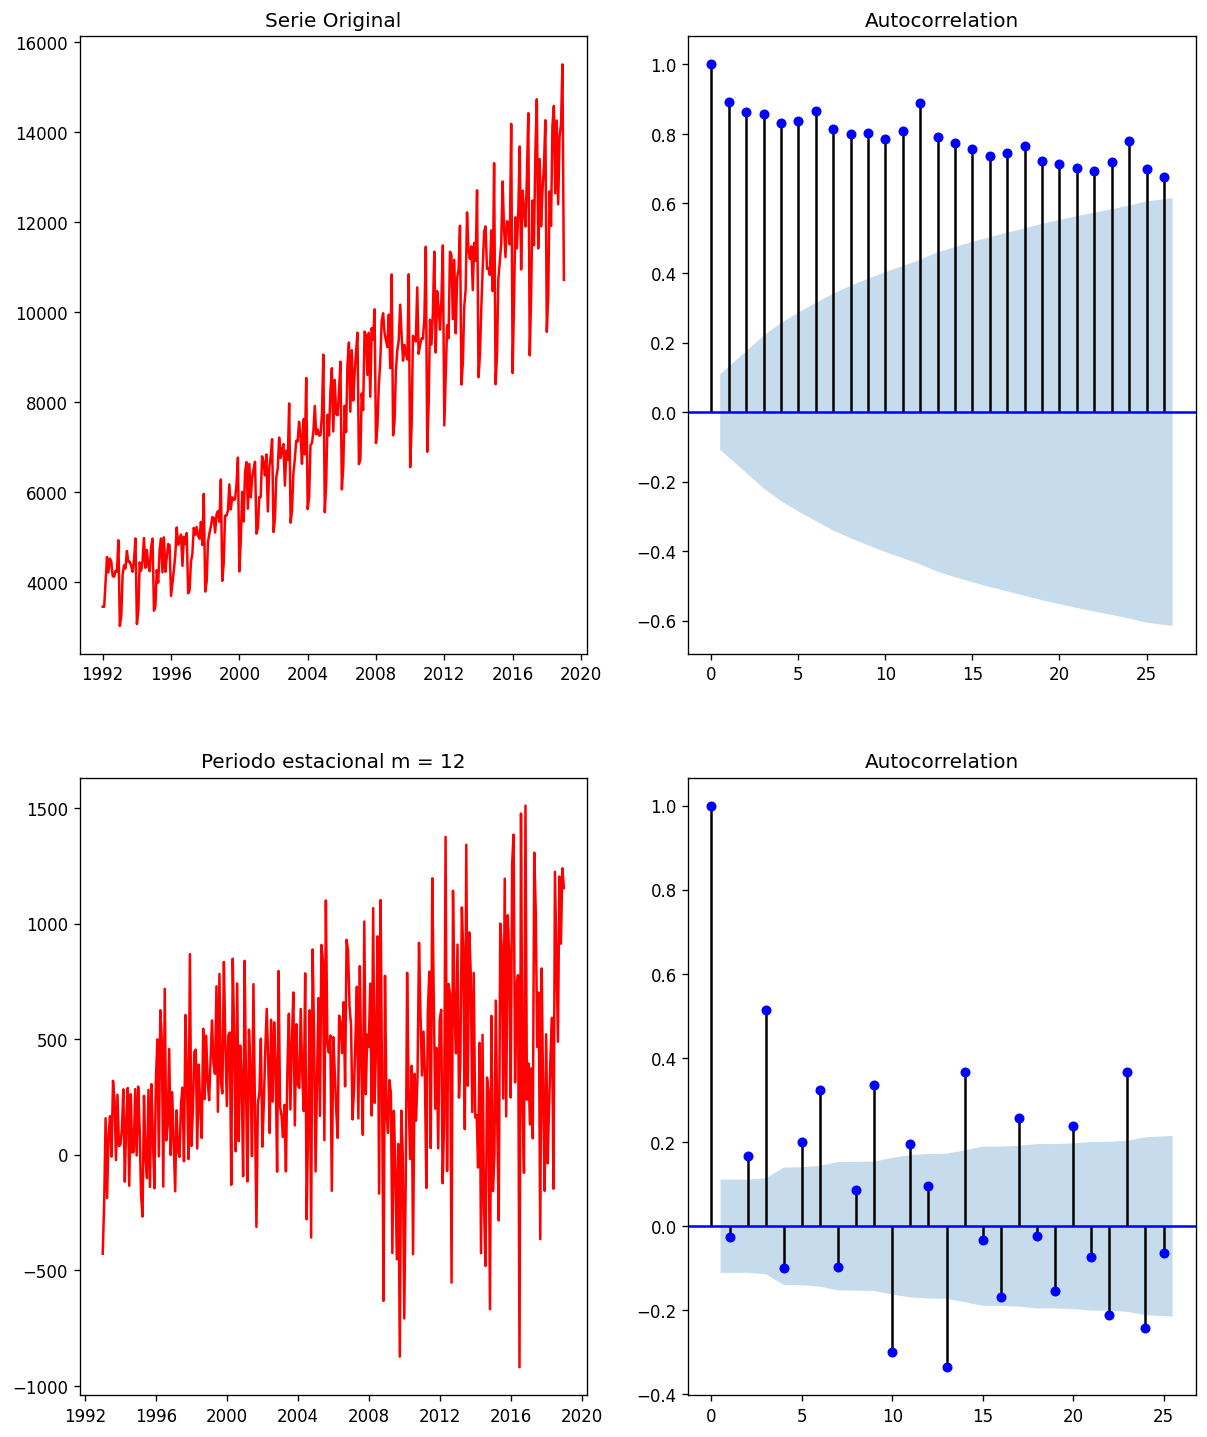

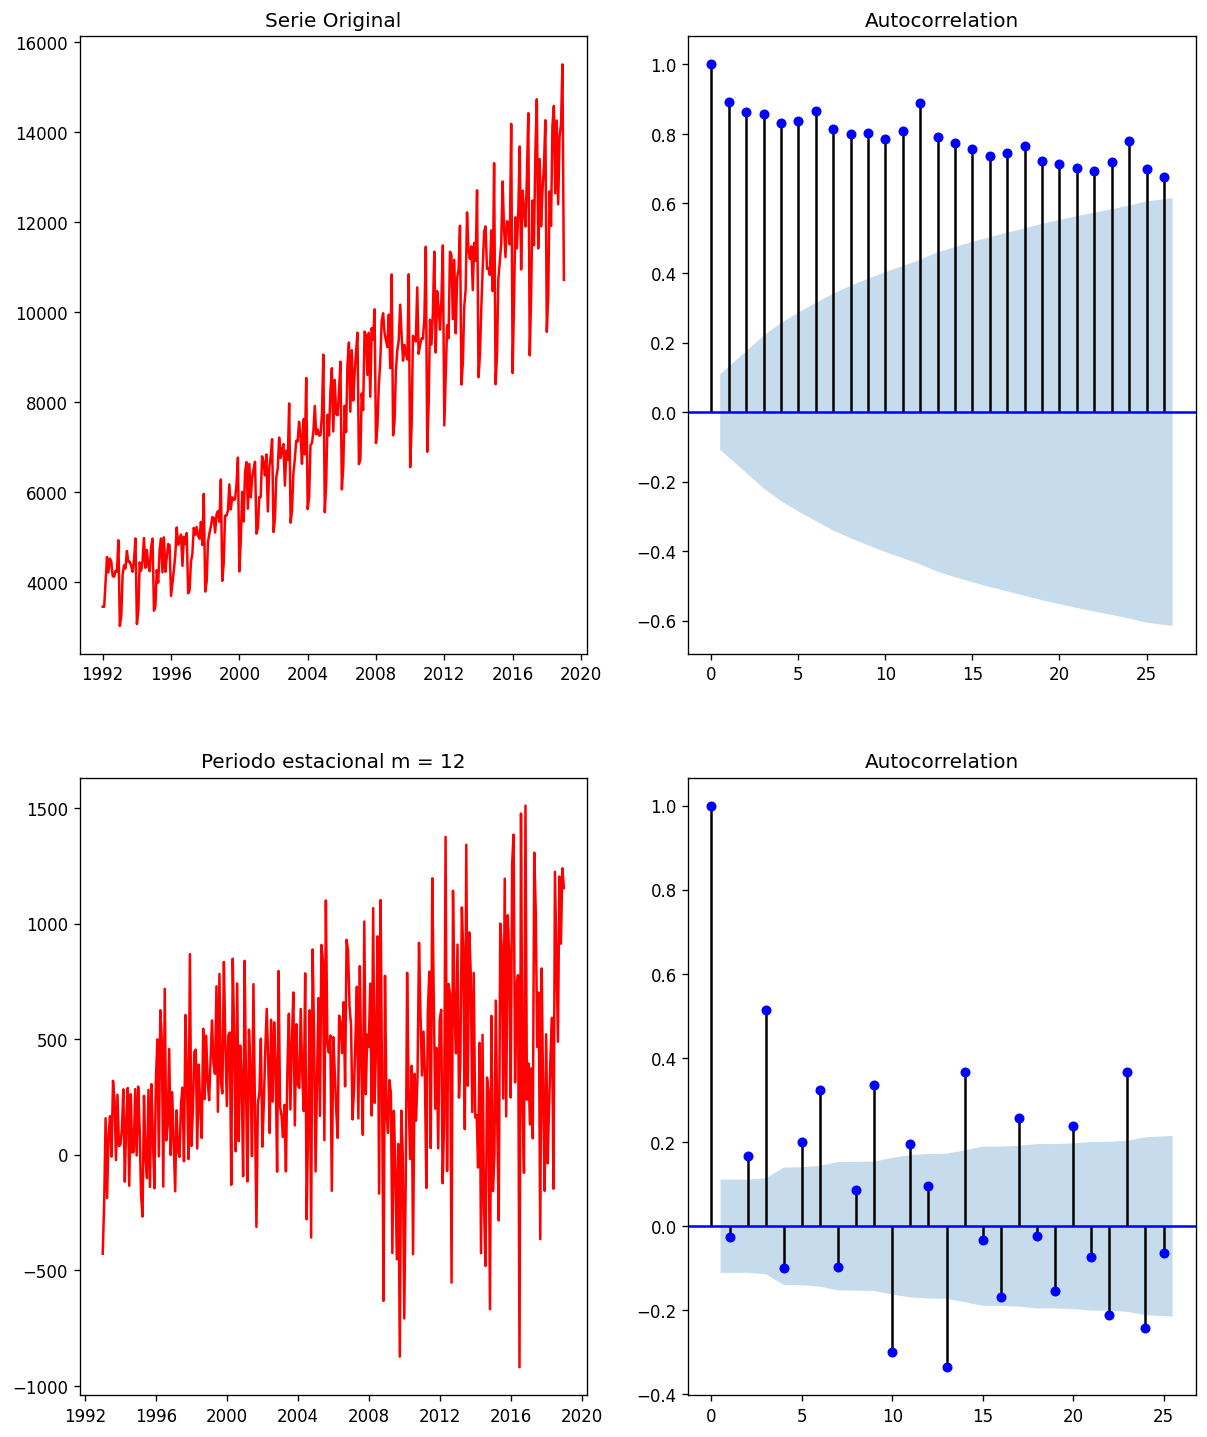

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,15),dpi=120)
#Serie original
axes[0,0].plot(df['VENTAS'], color = 'r'); axes[0,0].set_title('Serie Original')
plot_acf(df['VENTAS'], ax=axes[0,1], color = 'b')

#Periodo estacional m = 12
axes[1,0].plot(df['VENTAS'].diff(12), color = 'r'); axes[1,0].set_title('Periodo estacional m = 12')
plot_acf(df['VENTAS'].diff(12).dropna(), ax=axes[1,1], color = 'b')


Como se puede obervar en la serie anterior se puede osbervar que la serie alcanza cierta estacionariedad desde la primera diferenciación utilizando un valor m = 12 ya que la serie tiene un patrón cada año, Se continuará con el proceso de diferenciación.

# Diferenciación de la serie

In [ ]:
diff_df = df['VENTAS'].diff(12).diff(1)

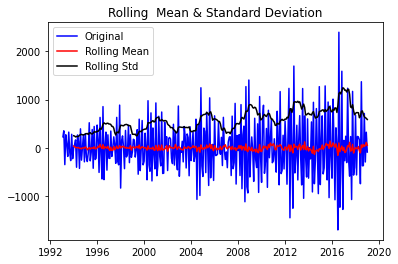

Results of Dickey-Fuller Test:
Test Statistic                -6.805335e+00
p-value                        2.184072e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.980000e+02
Critical Value (1%)           -3.452486e+00
Critical Value (5%)           -2.871288e+00
Critical Value (10%)          -2.571964e+00
dtype: float64
Results of kpss Test:
Test Statistic            0.055894
p-value                   0.100000
#Lags Used               16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [ ]:
test_stationarity(diff_df.dropna())

Como se observa obtuvimos un comportamiento estacionario, podemos seguir diferenciando la serie para obtener mejores resultados pero esto podría provocar una sobreestacionariedad por lo que se dejará con una diferenciación. Además vemos que el p-value de la prueba de Dickey fuller es menor a 0.05 por lo que se rechaza la hipótesis nula lo que quiere decir que los datos son estacionarios.


Por lo que obtenemos los siguientes valores para el modelo

*   D = 1

*   d = 1







# Autocorrelación y Autocorrelación parcial de la serie diferenciada

A continuación se grafica la autocorrelación y autocorrelación parcial de la serie ya diferenciada.

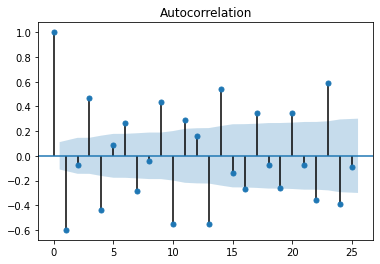

In [ ]:
plot_acf(diff_df.dropna())
plt.show()

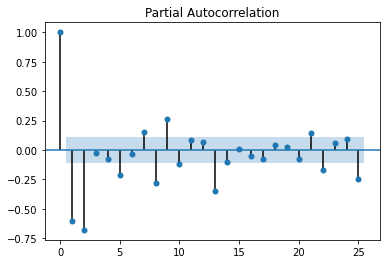

In [ ]:
plot_pacf(diff_df.dropna())
plt.show()

Gracias al gráfico de autocorrelación podemos sugerir una q = 1 debido a que es un valor significativo y Q = 0. Con la gráfica de autocorrelación parcial podemos sugerir una p = 2 debido que es un valor significativo y una P = 0. Finalmente obtendríamos un modelo (2,1,2)x(0,1,0,12)

# Construyendo modelo SARIMAX

In [ ]:
model = sm.tsa.statespace.SARIMAX(df, order=(2,1,1), seasonal_order=(0,1,0,12))
res = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              VENTAS   No. Observations:                  325
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood               -2269.217
Date:                             Thu, 01 Dec 2022   AIC                           4546.435
Time:                                     00:26:44   BIC                           4561.407
Sample:                                 01-01-1992   HQIC                          4552.419
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9717      0.056    -17.273      0.000      -1.082      -0.861
ar.L2         -0.6526      0.047    -13.925      0.000      -0.744      -0.561
ma.L1         -0.0475      0.075     -0.637      0.524      -0.194       0.099
sigma2       1.22e+05   8167.238     14.936      0.000    1.06e+05    1.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.26
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.78   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prob(Q) = 0.80 > 0,05.  No debemos rechazar la hipótesis nula de que los residuos no están correlacionados por lo que los residuos no están correlacionados. 

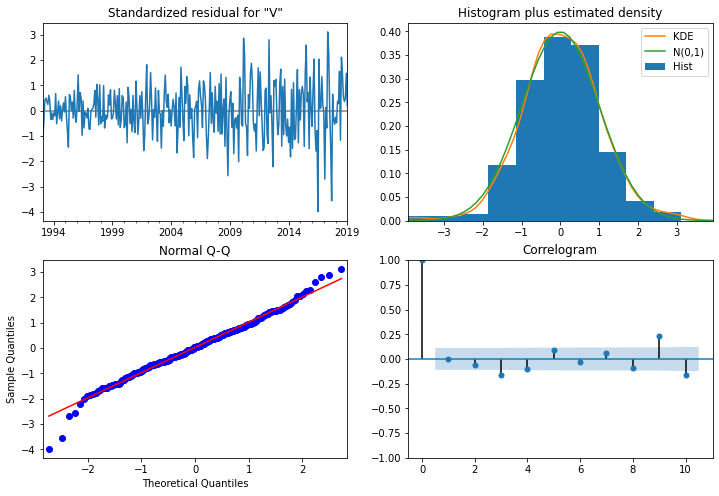

In [ ]:
res.plot_diagnostics(figsize=(12,8))
plt.show()

Para un modelo ideal, los residuos deben estar descorrelacionados con el ruido centrado en cero. Analizando los gráficos anteriores teniendo esto en cuenta podemos evaluar si tenemos un buen modelo o no.

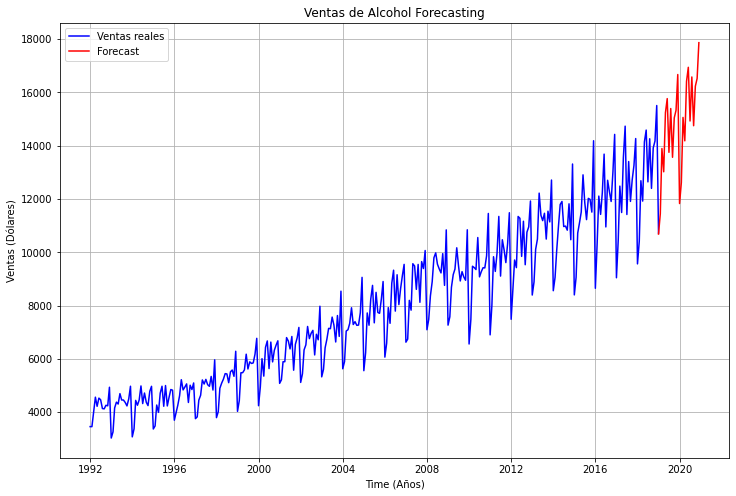

In [ ]:
forecast = res.predict(start='2019-01-01', end='2020-12-01', signal_only=True, dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.index, df['VENTAS'], label='Ventas reales', color='b')
ax.plot(forecast, label='Forecast', color='r')
ax.set_title('Ventas de Alcohol Forecasting')
ax.set_ylabel('Ventas (Dólares)')
ax.grid(True)
ax.set_xlabel('Time (Años)')
plt.legend()
plt.show()